# Imports and connections

In [66]:
from getpass import getpass

from numpy.ma.extras import unique
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy import stats
from plotly.subplots import make_subplots

In [67]:
DATASET = 'vishakhdapat/customer-segmentation-clustering'
FILE_NAME = 'EXAMPLE.csv'

SEED = 5

TARGET = ''

# Data load

In [68]:
from pathlib import Path

path = kagglehub.dataset_download(DATASET)

dataset_path = Path(path)
csv_files = list(dataset_path.glob('*.csv'))

if len(csv_files) == 0:
    raise FileNotFoundError(f"В директории {dataset_path} не найдено CSV-файлов")
elif len(csv_files) > 1:
    if FILE_NAME is not None:
        target_file = dataset_path / FILE_NAME
        if target_file.exists():
            csv_file = target_file

        else:
            raise FileNotFoundError(f"Заданный файл {FILE_NAME} не найден в директории {dataset_path}")
    else:
        raise ValueError(f"В директории {dataset_path} найдено несколько CSV-файлов: {[f.name for f in csv_files]}.")
else:
    csv_file = csv_files[0]

df = pd.read_csv(csv_file)
print(f"Успешно загружен файл: {csv_file.name}")


Успешно загружен файл: customer_segmentation.csv


# Data Analysis

## Общий обзор

In [69]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [71]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


Описание фичей:

* Id: Уникальный идентификатор для каждого элемента в наборе данных.
* Year_Birth: Год рождения человека.
* Education: наивысший уровень образования, которого достиг человек.
* Marital_Status: Семейное положение человека.
* Income: годовой доход физического лица.
* Kidhome: Количество маленьких детей в семье.
* Teenhome: Количество подростков в семье.
* Dt_Customer: дата, когда клиент был впервые зарегистрирован или стал частью базы данных компании.
* Recency: количество дней, прошедших с момента последней покупки или взаимодействия.
* MntWines: Сумма, потраченная на вино.
* MntFruits: Сумма, потраченная на фрукты.
* MntMeatProducts: Сумма, потраченная на мясные продукты.
* MntFishProducts: Сумма, потраченная на рыбные продукты.
* MntSweetProducts: Сумма, потраченная на сладости.
* MntGoldProds: сумма, потраченная на изделия из золота.
* NumDealsPurchases: количество покупок, совершённых со скидкой или в рамках акции.
* NumWebPurchases: количество покупок, совершённых на сайте компании.
* NumCatalogPurchases: количество покупок, совершённых по каталогам.
* NumStorePurchases: количество покупок, совершённых в обычных магазинах.
* NumWebVisitsMonth: количество посещений сайта компании за месяц.
* AcceptedCmp3: Бинарный индикатор (1 или 0), показывающий, принял ли пользователь третью маркетинговую кампанию.
* AcceptedCmp4: Бинарный индикатор (1 или 0), показывающий, принял ли пользователь четвёртую маркетинговую кампанию.
* AcceptedCmp5: Бинарный индикатор (1 или 0), показывающий, принял ли пользователь пятую маркетинговую кампанию.
* AcceptedCmp1: Бинарный индикатор (1 или 0), показывающий, принял ли пользователь первую маркетинговую кампанию.
* AcceptedCmp2: Бинарный индикатор (1 или 0), показывающий, принял ли пользователь вторую маркетинговую кампанию.
* Complain: Бинарный индикатор (1 или 0), указывающий, подавал ли человек жалобу.
* Z_CostContact: Постоянные расходы, связанные с обращением к клиенту.
* Z_Revenue: Постоянный доход, связанный с успешным откликом на кампанию.
* Response: Бинарный индикатор (1 или 0), показывающий, отреагировал ли человек на маркетинговую кампанию.

## Проверка на null

In [72]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [73]:
df['Income'] = df['Income'].fillna(df['Income'].median())

In [74]:
df.isnull().sum().sum()

np.int64(0)

## Категориальные признаки

In [75]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)

In [76]:
for col in categorical_columns:
    unique_vals = df[col].unique()
    print(f"Колонка '{col}': {len(unique_vals)} уникальных значений")

df[categorical_columns]

Колонка 'Education': 5 уникальных значений
Колонка 'Marital_Status': 8 уникальных значений
Колонка 'Dt_Customer': 663 уникальных значений


,Education,Marital_Status,Dt_Customer
0,Graduation,Single,04-09-2012
1,Graduation,Single,08-03-2014
2,Graduation,Together,21-08-2013
3,Graduation,Together,10-02-2014
4,PhD,Married,19-01-2014
...,...,...,...
2235,Graduation,Married,13-06-2013
2236,PhD,Together,10-06-2014
2237,Graduation,Divorced,25-01-2014
2238,Master,Together,24-01-2014


In [77]:
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'])

Работа с датами

In [78]:
current_date = datetime.now()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

df['Customer_Seniority_Days'] = (current_date - df['Dt_Customer']).dt.days
df['Registration_Month'] = df['Dt_Customer'].dt.month

## Создание новых признаков

In [79]:
# Демографические признаки
df['Age'] = 2025 - df['Year_Birth']
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Has_Children'] = (df['Total_Children'] > 0).astype(int)

# Экономическое поведение
df['Total_Spending'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] +
                       df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['Spending_Per_Income'] = df['Total_Spending'] / df['Income']

# Активность покупок
df['Total_Purchases'] = (df['NumDealsPurchases'] + df['NumWebPurchases'] +
                        df['NumCatalogPurchases'] + df['NumStorePurchases'])
df['Average_Spending_Per_Purchase'] = df['Total_Spending'] / df['Total_Purchases']
df['Total_Purchases'] = df['Total_Purchases'].replace([np.inf, -np.inf], 0)
df['Average_Spending_Per_Purchase'] = df['Average_Spending_Per_Purchase'].replace([np.inf, -np.inf], 0)

# Восприимчивость к маркетингу
df['Total_Accepted_Campaigns'] = (df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] +
                                 df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response'])

Хлам удалить

In [80]:
df.columns

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO', 'Customer_Seniority_Days', 'Registration_Month',
       'Age', 'Total_Children', 'Has_Children', 'Total_Spending',
       'Spending_Per_Income', 'Total_Purchases',
       'Average_Spending_

In [81]:
df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
df = df.drop(['Dt_Customer'], axis=1)
df = df.drop(['Year_Birth'], axis=1)

print(f"Размерность после очистки: {df.shape}")

Размерность после очистки: (2240, 45)


## Числовые признаки

Масштабирование

In [82]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# scaler = StandardScaler()
# df = df.copy()
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

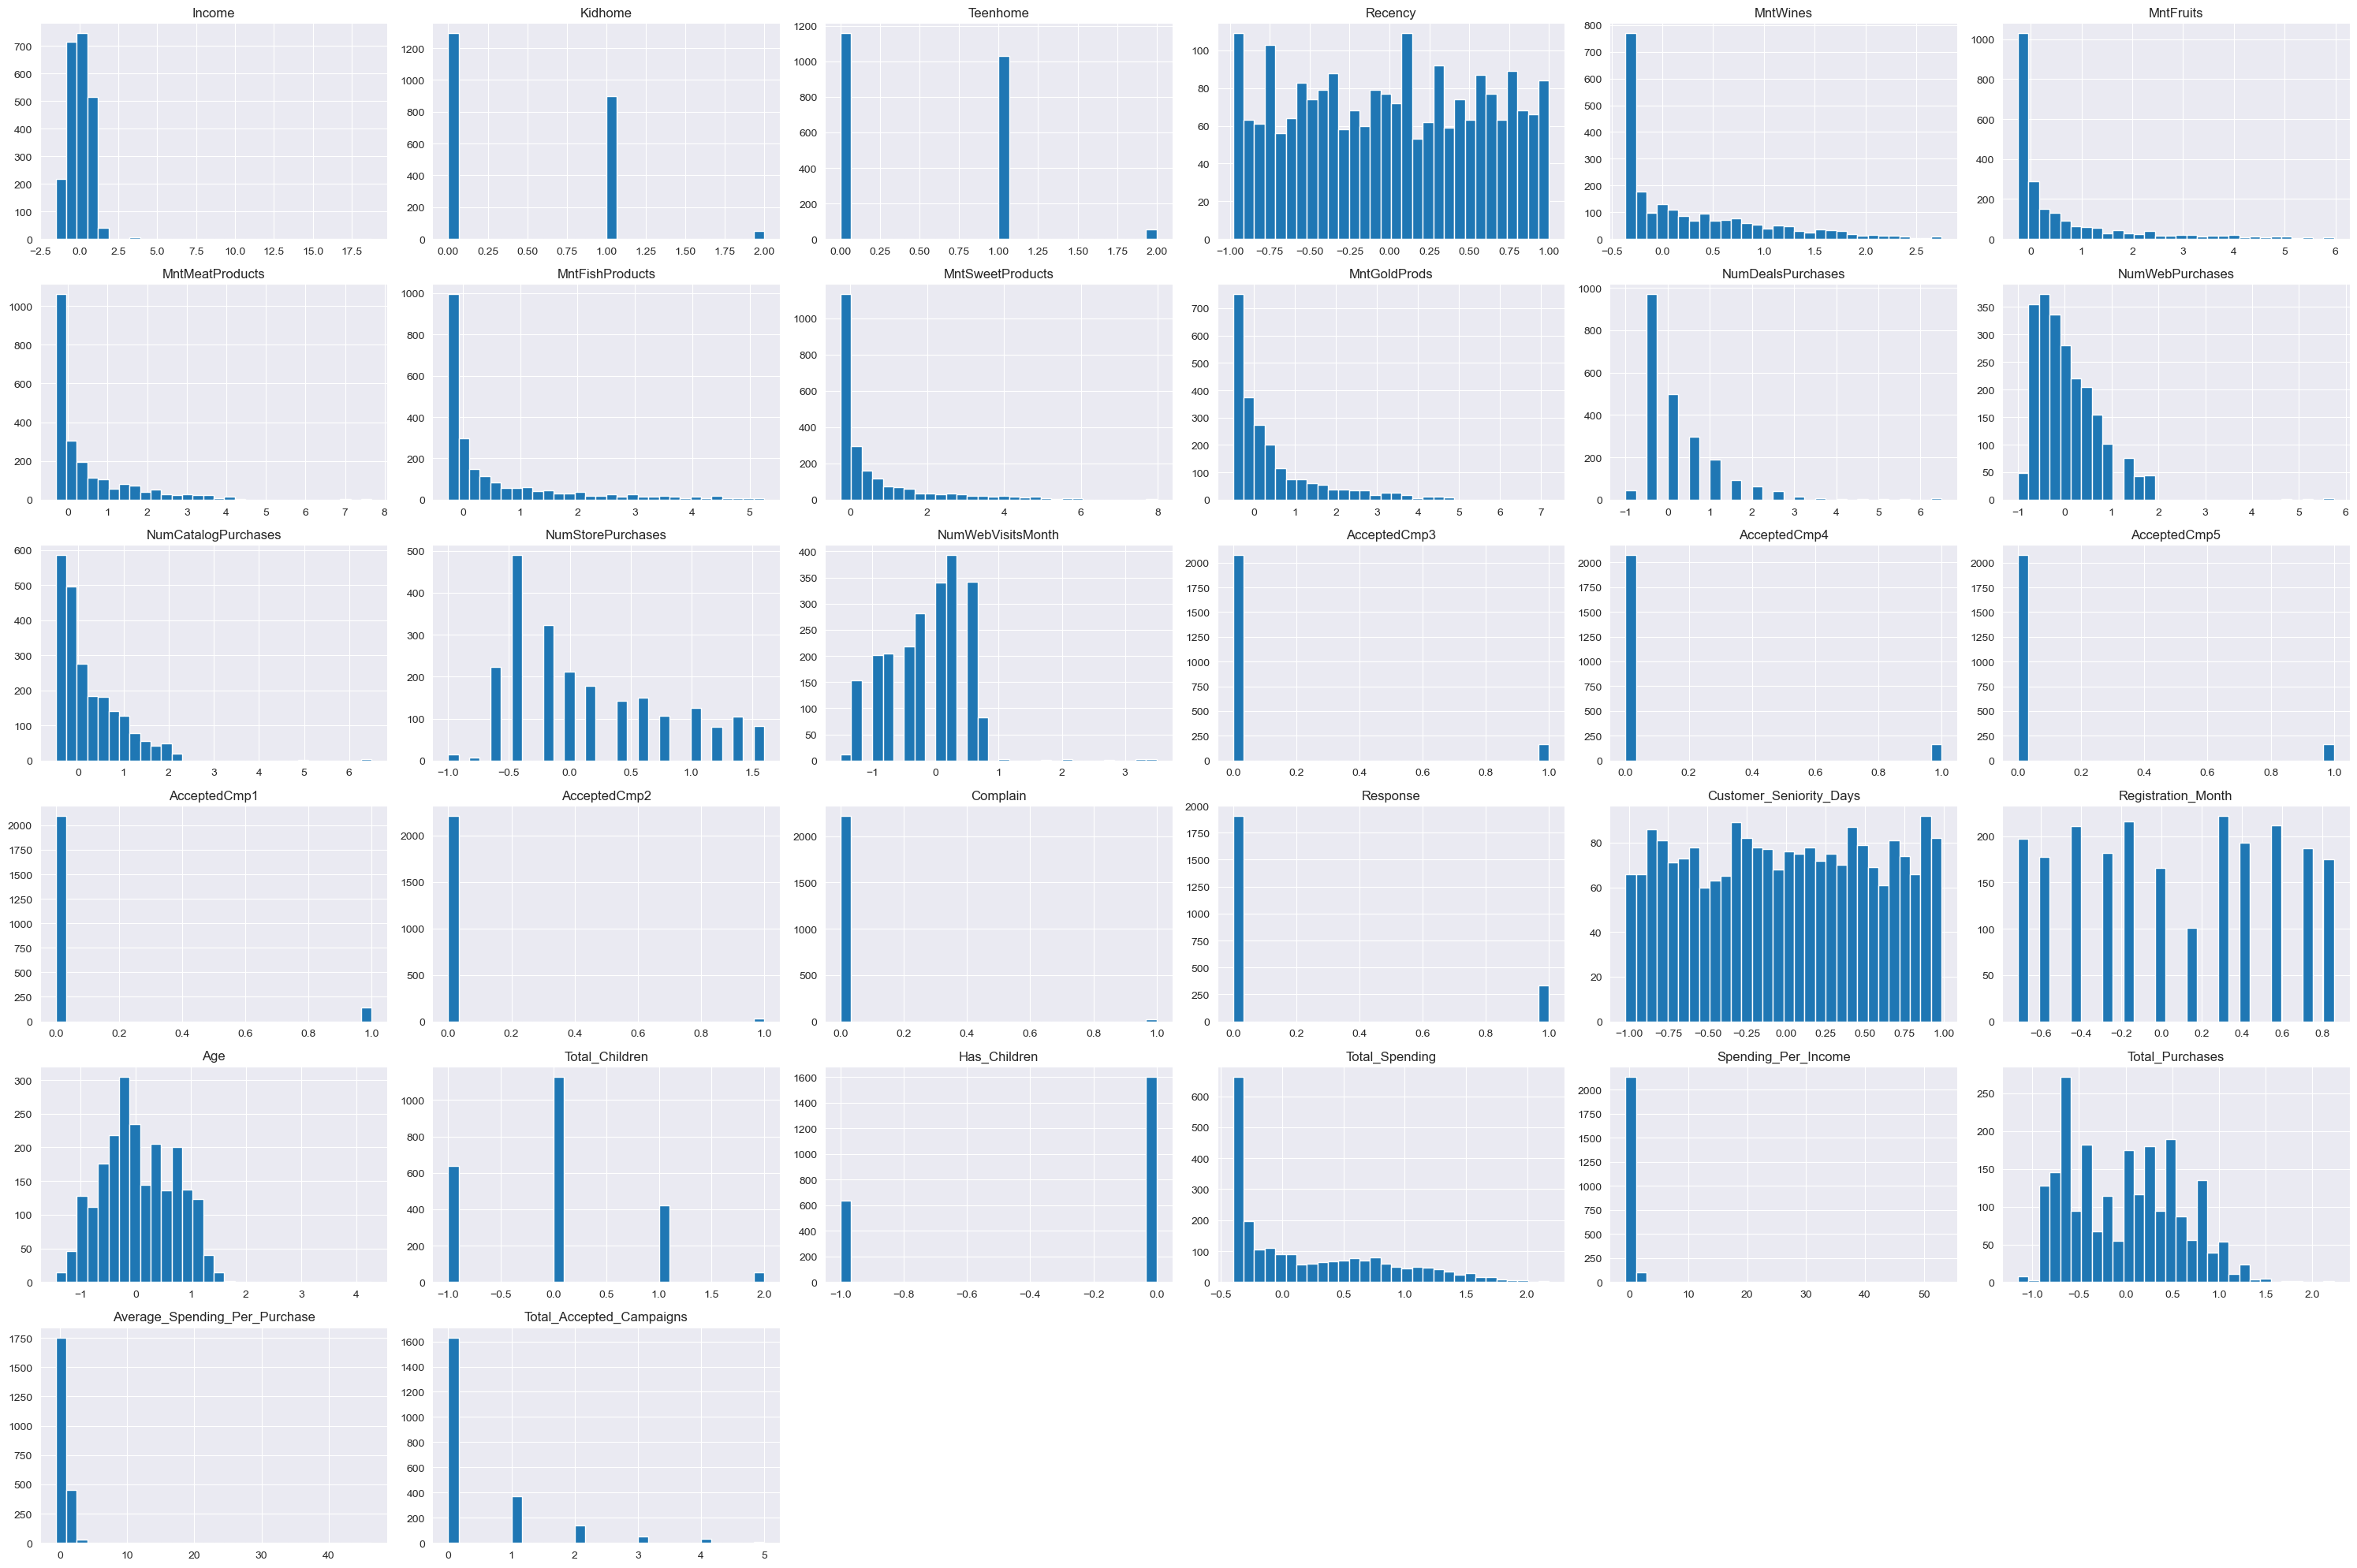

In [83]:
df[numeric_columns].hist(bins=30, figsize=(30, 20))
plt.tight_layout()
plt.show()

## Выбросы

In [85]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO',
       'Customer_Seniority_Days', 'Registration_Month', 'Age',
       'Total_Children', 'Has_Children', 'Total_Spending',
       'Spending_Per_Income', 'Total_Purchases',
       'Average_Spending_Per_Purchase', 'Total_Accepted_Campaigns'],
      dtype='object')

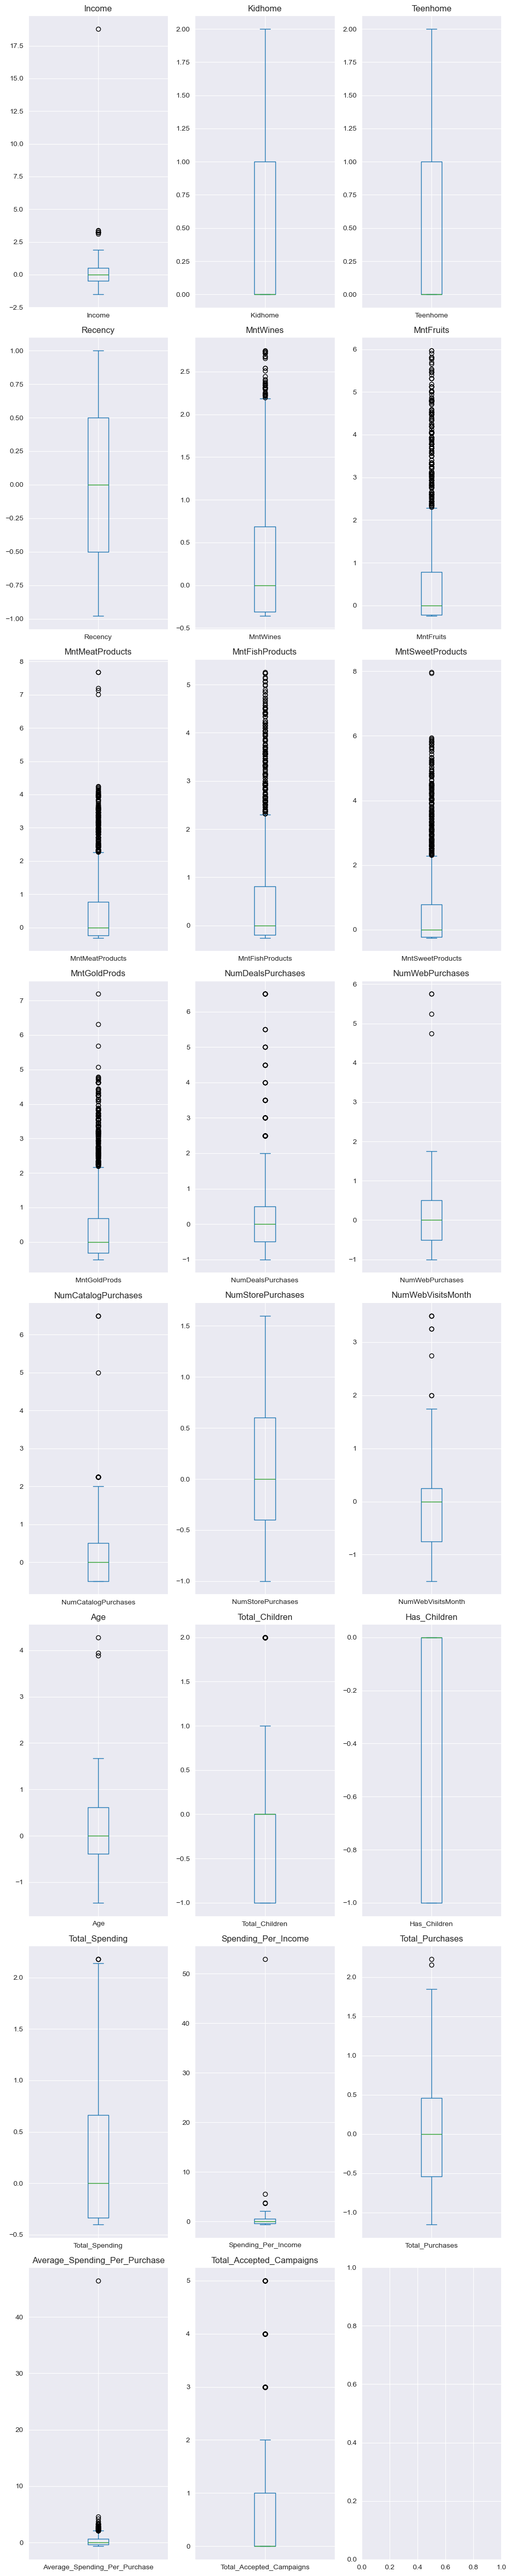

In [90]:
plt.show()
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 50))
axes = axes.flatten()

col = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Age',
       'Total_Children', 'Has_Children', 'Total_Spending',
       'Spending_Per_Income', 'Total_Purchases',
       'Average_Spending_Per_Purchase', 'Total_Accepted_Campaigns']

for i, col in enumerate(col):
    df[col].plot.box(ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

# Models

# Results